### STEP 1.1 — Create project folders & extract zips

In [1]:
import os
import zipfile

base_dir = r"C:\Users\ShaownJony\Downloads\Project"
project_dir = os.path.join(base_dir, "AI-Crisis-Tweet-Classifier", "data", "raw")
os.makedirs(project_dir, exist_ok=True)

zip_paths = [
    r"C:\Users\ShaownJony\Downloads\Project\CrisisLexT26-v1.0.zip",
    r"C:\Users\ShaownJony\Downloads\Project\CrisisLexT6-v1.0.zip"
]

for z in zip_paths:
    print("Extracting:", z)
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall(project_dir)
print("Extraction done. Root data folder:", project_dir)

Extracting: C:\Users\ShaownJony\Downloads\Project\CrisisLexT26-v1.0.zip
Extracting: C:\Users\ShaownJony\Downloads\Project\CrisisLexT6-v1.0.zip
Extraction done. Root data folder: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\raw


### STEP 1.2 — Inspect folder structure (list files & sample few files)

In [2]:
import os
import pandas as pd

# === 1️⃣ Set your base data directory ===
data_root = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\raw" # change if needed

# === 2️⃣ Walk through both datasets and list all subfolders & file counts ===
print("📁 Folder tree overview:\n")
for root, dirs, files in os.walk(data_root):
    depth = root.replace(data_root, "").count(os.sep)
    indent = "  " * depth
    print(f"{indent}{os.path.basename(root)}/  ({len(files)} files)")
    for f in files[:5]:   
        print(f"{indent}  ├── {f}")
    if depth == 2:        
        continue
print("\n✅ Folder structure inspection complete.")

# === 3️⃣ Preview a sample event from each dataset ===
# CrisisLexT26 example: "2013_Boston_bombings"
t26_event = os.path.join(data_root, "CrisisLexT26", "2013_Boston_bombings")
t26_files = [f for f in os.listdir(t26_event) if f.endswith(('.csv', '.txt'))]
print("\n📂 CrisisLexT26 → 2013_Boston_bombings contains:", t26_files)

# Load and preview first file safely
sample_t26 = os.path.join(t26_event, t26_files[0])
try:
    df_t26 = pd.read_csv(sample_t26, encoding='utf-8', nrows=5)
except:
    df_t26 = pd.read_csv(sample_t26, encoding='latin1', sep='\t', nrows=5)

print("\n🔍 Preview of T26 sample file:", t26_files[0])
print(df_t26.head(), "\nColumns:", list(df_t26.columns))

# CrisisLexT6 example: "2013_Boston_Bombings"
t6_event = os.path.join(data_root, "CrisisLexT6", "2013_Boston_Bombings")
t6_files = [f for f in os.listdir(t6_event) if f.endswith(('.csv', '.txt'))]
print("\n📂 CrisisLexT6 → 2013_Boston_Bombings contains:", t6_files)

# Load and preview first file safely
sample_t6 = os.path.join(t6_event, t6_files[0])
try:
    df_t6 = pd.read_csv(sample_t6, encoding='utf-8', nrows=5)
except:
    df_t6 = pd.read_csv(sample_t6, encoding='latin1', sep='\t', nrows=5)

print("\n🔍 Preview of T6 sample file:", t6_files[0])
print(df_t6.head(), "\nColumns:", list(df_t6.columns))

📁 Folder tree overview:

raw/  (0 files)
  CrisisLexT26/  (2 files)
    ├── .DS_Store
    ├── README.md
    2012_Colorado_wildfires/  (4 files)
      ├── 2012_Colorado_wildfires-event_description.json
      ├── 2012_Colorado_wildfires-tweetids_entire_period.csv
      ├── 2012_Colorado_wildfires-tweets_labeled.csv
      ├── README.md
    2012_Costa_Rica_earthquake/  (4 files)
      ├── 2012_Costa_Rica_earthquake-event_description.json
      ├── 2012_Costa_Rica_earthquake-tweetids_entire_period.csv
      ├── 2012_Costa_Rica_earthquake-tweets_labeled.csv
      ├── README.md
    2012_Guatemala_earthquake/  (4 files)
      ├── 2012_Guatemala_earthquake-event_description.json
      ├── 2012_Guatemala_earthquake-tweetids_entire_period.csv
      ├── 2012_Guatemala_earthquake-tweets_labeled.csv
      ├── README.md
    2012_Italy_earthquakes/  (4 files)
      ├── 2012_Italy_earthquakes-event_description.json
      ├── 2012_Italy_earthquakes-tweetids_entire_period.csv
      ├── 2012_Italy_earthqu

### STEP 1.3 — Load and Merge All Event Files Automatically

In [3]:
import os
import pandas as pd
import re

data_root = r"C:\Users\ShaownJony\Downloads\crisislex\data\AI-Crisis-Tweet-Classifier\data"
t26_path = os.path.join(data_root, "CrisisLexT26")
t6_path  = os.path.join(data_root, "CrisisLexT6")
all_rows = []

def normalize_id(x):
    if pd.isna(x):
        return x
    s = str(x).strip()
    s = re.sub(r"^['\"]+|['\"]+$", "", s)
    return s

# ---- Load T26 (tweets_labeled + optional tweetids) ----
for event in sorted(os.listdir(t26_path)):
    event_path = os.path.join(t26_path, event)
    if not os.path.isdir(event_path):
        continue

    labeled_file = None
    ids_file = None
    for f in os.listdir(event_path):
        if f.endswith("-tweets_labeled.csv"):
            labeled_file = os.path.join(event_path, f)
        elif f.endswith("-tweetids_entire_period.csv"):
            ids_file = os.path.join(event_path, f)

    if labeled_file is None:
        continue


    try:
        df_label = pd.read_csv(labeled_file, encoding="utf-8", low_memory=False)
    except Exception:
        df_label = pd.read_csv(labeled_file, encoding="latin1", low_memory=False)

    # normalize column names (lowercase, strip)
    df_label.columns = [str(c).strip().lower() for c in df_label.columns]

    # heuristics to find id,text,label columns
    id_col = next((c for c in df_label.columns if 'id' in c), None)
    text_col = next((c for c in df_label.columns if 'text' in c), None)
    label_col = next((c for c in df_label.columns if c in ('informativeness','information type','information_source','information_source'.lower())), None)
    if label_col is None:
        label_col = next((c for c in df_label.columns if 'label' in c or 'class' in c or 'informativ' in c), None)

    if text_col is None:
        # try other heuristics if 'text' not found (e.g., column named 'tweet' or 'tweet text')
        text_col = next((c for c in df_label.columns if 'tweet' in c), None)

    if text_col is None:
        print(f"⚠ Skipping {event} — no text column detected in labeled file.")
        continue

    sub = pd.DataFrame({
        'tweet_id': df_label[id_col].astype(str) if id_col else pd.NA,
        'tweet_text': df_label[text_col].astype(str),
        'label': df_label[label_col] if label_col else pd.NA,
        'event': event,
        'source': 'T26',
        'orig_file': labeled_file
    })

    # normalize tweet_id strings
    if 'tweet_id' in sub.columns:
        sub['tweet_id'] = sub['tweet_id'].apply(normalize_id)

    # merge timestamp from ids_file (optional)
    if ids_file:

        try:
            df_ids = pd.read_csv(ids_file, encoding="utf-8", low_memory=False)
        except Exception:
            df_ids = pd.read_csv(ids_file, encoding="latin1", low_memory=False)
        df_ids.columns = [str(c).strip().lower() for c in df_ids.columns]
        id_col2 = next((c for c in df_ids.columns if 'id' in c), None)
        time_col = next((c for c in df_ids.columns if 'time' in c or 'timestamp' in c), None)
        if id_col2 and time_col:
            df_ids[id_col2] = df_ids[id_col2].astype(str).apply(normalize_id)
            sub = sub.merge(df_ids[[id_col2, time_col]].rename(columns={id_col2:'tweet_id', time_col:'timestamp'}),
                            on='tweet_id', how='left')
    all_rows.append(sub)

print("✅ T26 loaded and processed (text + labels where available).")

# ---- Load T6 (flexible handling) ----
for event in sorted(os.listdir(t6_path)):
    event_path = os.path.join(t6_path, event)
    if not os.path.isdir(event_path):
        continue
    for f in os.listdir(event_path):
        if f.endswith("-ontopic_offtopic.csv"):
            path = os.path.join(event_path, f)
            try:
                df = pd.read_csv(path, encoding="utf-8", low_memory=False)
            except Exception:
                df = pd.read_csv(path, encoding="latin1", low_memory=False)

            df.columns = [str(c).strip().lower() for c in df.columns]

            id_col = next((c for c in df.columns if 'id' in c), None)
            text_col = next((c for c in df.columns if 'tweet' in c and 'id' not in c), None)
            label_col = next((c for c in df.columns if 'label' in c), None)

            if id_col is None or text_col is None or label_col is None:
                print(f"⚠ Warning: couldn't detect all columns in {path}. Columns: {df.columns.tolist()}")
                cols = df.columns.tolist()
                if len(cols) >= 3:
                    id_col, text_col, label_col = cols[0], cols[1], cols[2]
                else:
                    continue


            sub = pd.DataFrame({
                'tweet_id': df[id_col].astype(str).apply(normalize_id),
                'tweet_text': df[text_col].astype(str),
                'label': df[label_col].astype(str),
                'event': event,
                'source': 'T6',
                'orig_file': path
            })
            all_rows.append(sub)

print("✅ T6 loaded and processed.")

# ---- Concatenate all and save ----
merged_raw = pd.concat(all_rows, ignore_index=True)
print("\n📊 Merged dataset shape:", merged_raw.shape)
print("Columns:", list(merged_raw.columns))

# Save
output_dir = os.path.join(r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data","processed")
os.makedirs(output_dir, exist_ok=True)
out_path = os.path.join(output_dir, "merged_raw_firstpass.csv")
merged_raw.to_csv(out_path, index=False, encoding="utf-8")
print("💾 Saved merged dataset to:", out_path)

merged_raw.head(8)

✅ T26 loaded and processed (text + labels where available).
✅ T6 loaded and processed.

📊 Merged dataset shape: (88067, 7)
Columns: ['tweet_id', 'tweet_text', 'label', 'event', 'source', 'orig_file', 'timestamp']
💾 Saved merged dataset to: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\merged_raw_firstpass.csv


,tweet_id,tweet_text,label,event,source,orig_file,timestamp
0,211040709124440064,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,2012_Colorado_wildfires,T26,C:\Users\ShaownJony\Downloads\crisislex\data\A...,Fri Jun 08 10:23:20 +0000 2012
1,211111710294163457,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,2012_Colorado_wildfires,T26,C:\Users\ShaownJony\Downloads\crisislex\data\A...,Fri Jun 08 15:05:28 +0000 2012
2,211157222699433985,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,2012_Colorado_wildfires,T26,C:\Users\ShaownJony\Downloads\crisislex\data\A...,Fri Jun 08 18:06:19 +0000 2012
3,211162553659830272,Denver Post: #Colorado governor signs bill cre...,Not labeled,2012_Colorado_wildfires,T26,C:\Users\ShaownJony\Downloads\crisislex\data\A...,Fri Jun 08 18:27:30 +0000 2012
4,211216962162933761,Pretty sure I'm going to live in Manitou Sprin...,Not labeled,2012_Colorado_wildfires,T26,C:\Users\ShaownJony\Downloads\crisislex\data\A...,Fri Jun 08 22:03:42 +0000 2012
5,211229146611843072,Flying over the beautiful snow capped #mountai...,Not labeled,2012_Colorado_wildfires,T26,C:\Users\ShaownJony\Downloads\crisislex\data\A...,Fri Jun 08 22:52:07 +0000 2012
6,211232623706640384,It isn't a beach but just as great #colorado #...,Not labeled,2012_Colorado_wildfires,T26,C:\Users\ShaownJony\Downloads\crisislex\data\A...,Fri Jun 08 23:05:56 +0000 2012
7,211281973870727170,#colorado. Told you its #amazing http://t.co/6...,Not labeled,2012_Colorado_wildfires,T26,C:\Users\ShaownJony\Downloads\crisislex\data\A...,Sat Jun 09 02:22:02 +0000 2012


### STEP 2.1 — Inspect the merged file and collect basic stats

In [4]:
import pandas as pd

path = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\merged_raw_firstpass.csv"
df = pd.read_csv(path, low_memory=False)

print("✅ Loaded merged file")
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))

# how many have tweet_text
n_text = df['tweet_text'].notna().sum()
n_notext = df['tweet_text'].isna().sum()
print(f"\nTweet text present: {n_text}  |  missing: {n_notext}")

# source breakdown
print("\nSource counts:")
print(df['source'].value_counts(dropna=False))

# label availability
print("\nLabel missing count:", df['label'].isna().sum())
print("Label value counts (top 20):")
print(df['label'].value_counts(dropna=False).head(20))

# top events
print("\nTop 15 events by row count:")
print(df['event'].value_counts().head(15))

# duplicates
dup_id = df['tweet_id'].duplicated().sum()
dup_text = df['tweet_text'].duplicated().sum()
print(f"\nDuplicate tweet_id rows: {dup_id}")
print(f"Duplicate tweet_text rows: {dup_text}")

# sample rows from each source
print("\n--- Sample (T26) ---")
display(df[df['source']=='T26'].sample(5, random_state=42)[['tweet_id','tweet_text','label','event','timestamp']])
print("\n--- Sample (T6) ---")
display(df[df['source']=='T6'].sample(5, random_state=42)[['tweet_id','tweet_text','label','event']])

# save a quick preview CSV of first 500 rows for manual inspection (optional)
preview_path = path.replace("merged_raw_firstpass.csv","merged_preview_500.csv")
df.head(500).to_csv(preview_path, index=False, encoding='utf-8')
print("\nSaved merged preview (first 500 rows) to:", preview_path)

✅ Loaded merged file
Shape: (88067, 7)

Columns: ['tweet_id', 'tweet_text', 'label', 'event', 'source', 'orig_file', 'timestamp']

Tweet text present: 88067  |  missing: 0

Source counts:
source
T6     60082
T26    27985
Name: count, dtype: int64

Label missing count: 0
Label value counts (top 20):
label
on-topic                        32462
off-topic                       27620
Other Useful Information         7653
Affected individuals             4807
Sympathy and support             4651
Not labeled                      3424
Donations and volunteering       2404
Caution and advice               2306
Infrastructure and utilities     1602
Not applicable                   1138
Name: count, dtype: int64

Top 15 events by row count:
event
2013_Queensland_Floods           10033
2013_Alberta_Floods              10031
2013_Boston_Bombings             10012
2012_Sandy_Hurricane             10008
2013_West_Texas_Explosion        10006
2013_Oklahoma_Tornado             9992
2013_Russia_meteor 

,tweet_id,tweet_text,label,event,timestamp
23138,329050916680519682,Dhaka defends collapse aid refusal: Bangladesh...,Other Useful Information,2013_Savar_building_collapse,Tue Apr 30 01:53:46 +0000 2013
20615,302405233164832769,RT @koffboy: Какой суровый челябинский романти...,Sympathy and support,2013_Russia_meteor,Fri Feb 15 13:13:20 +0000 2013
27154,324735862850084864,RT @trentmkays: A man and his kid were recordi...,Affected individuals,2013_West_Texas_explosion,Thu Apr 18 04:07:17 +0000 2013
11276,323959501373976578,On Day 2 of my UNHappy Feet... :( ...with symp...,Sympathy and support,2013_Boston_bombings,Tue Apr 16 00:42:18 +0000 2013
27622,324911239295795200,RT @TrueTexasTea: Help for #West: @WacoTeaPart...,Not applicable,2013_West_Texas_explosion,Thu Apr 18 15:44:10 +0000 2013



--- Sample (T6) ---


,tweet_id,tweet_text,label,event
76042,295542495281025025,"Flash flood warning in australia, hodgers will...",on-topic,2013_Queensland_Floods
32924,263057055781376000,Ppl 's lights going off now its gettin real...,on-topic,2012_Sandy_Hurricane
67126,337690974736232448,RT @cydneysoleman: *tweets about how good Okla...,off-topic,2013_Oklahoma_Tornado
86764,328250060364197888,TEXAS UPROAR: Perry Says Cartoon Mocks Deaths ...,on-topic,2013_West_Texas_Explosion
86357,324707267175927808,RT @911BUFF: BREAKING NEWS COMING OUT OF TEXAS...,on-topic,2013_West_Texas_Explosion



Saved merged preview (first 500 rows) to: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\merged_preview_500.csv


### STEP 2.2 — Filter usable tweets (only with text)

In [5]:
df_text = df[df['tweet_text'].notna()].copy()

print("✅ Filtered usable text data.")
print("Original shape:", df.shape)
print("Filtered shape:", df_text.shape)

# Check data source counts
print("\nSource distribution:")
print(df_text['source'].value_counts())

# Show a few examples to confirm
df_text.sample(5, random_state=42)[['tweet_id', 'tweet_text', 'label', 'event', 'source']]

✅ Filtered usable text data.
Original shape: (88067, 7)
Filtered shape: (88067, 7)

Source distribution:
source
T6     60082
T26    27985
Name: count, dtype: int64


,tweet_id,tweet_text,label,event,source
56877,325078231973781504,"Retweet if you, like me, have friends on Faceb...",on-topic,2013_Boston_Bombings,T6
62280,338999386308755458,Takin a break eatin some noodles for breakfast...,off-topic,2013_Oklahoma_Tornado,T6
708,218010392465649665,.@thedirtydash is now Sept 1 in Colorado Sprin...,Not labeled,2012_Colorado_wildfires,T26
35457,263097999092219904,RT @TEAMElijahClark: We should all take the ti...,on-topic,2012_Sandy_Hurricane,T6
64300,337670984360419329,Things are being loaded up for the auction to ...,off-topic,2013_Oklahoma_Tornado,T6


### STEP 2.2: Clean Tweet Texts (Normalization)

In [6]:
import re
import pandas as pd

path = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\merged_raw_firstpass.csv"
df = pd.read_csv(path, low_memory=False)

def clean_tweet(text):
    t = str(text)
    is_rt = t.strip().upper().startswith("RT ")
    has_url = bool(re.search(r"http\S+|www\.\S+", t))
    # cleaning
    t = re.sub(r"http\S+|www\S+", "", t)      # remove URLs
    t = re.sub(r"@\w+", "", t)                # remove mentions
    t = re.sub(r"#", "", t)                   # remove hashtag symbol only
    t = re.sub(r"&amp;", " and ", t)          # html entity
    t = re.sub(r"[^A-Za-z\s]", " ", t)        # keep letters & spaces
    t = re.sub(r"\s+", " ", t).strip()        # normalize spaces
    t = t.lower()
    return t, is_rt, has_url

res = df['tweet_text'].apply(clean_tweet)
df['clean_text'] = res.apply(lambda x: x[0])
df['is_rt'] = res.apply(lambda x: x[1])
df['has_url'] = res.apply(lambda x: x[2])

# quick check
print("Applied cleaning. Example (original -> clean):")
display(df[['tweet_text','clean_text','is_rt','has_url']].sample(8, random_state=42))

# save updated file (overwrite or new name)
out = path.replace("merged_raw_firstpass.csv", "merged_raw_cleaned_text_firstpass.csv")
df.to_csv(out, index=False, encoding='utf-8')
print("Saved cleaned file to:", out)


Applied cleaning. Example (original -> clean):


,tweet_text,clean_text,is_rt,has_url
56877,"Retweet if you, like me, have friends on Faceb...",retweet if you like me have friends on faceboo...,False,False
62280,Takin a break eatin some noodles for breakfast...,takin a break eatin some noodles for breakfast,False,False
708,.@thedirtydash is now Sept 1 in Colorado Sprin...,is now sept in colorado springs want an entry ...,False,True
35457,RT @TEAMElijahClark: We should all take the ti...,rt we should all take the time to stop what we...,True,False
64300,Things are being loaded up for the auction to ...,things are being loaded up for the auction to ...,False,True
55285,The FBI wants these men in regards to the Bost...,the fbi wants these men in regards to the bost...,False,True
45143,RT @windspeakernews: RT @saambell: “@mmbaragar...,rt rt one of my students rescuing a fawn from ...,True,True
79606,@krissybrown73 @tx_navyfiance girl people don'...,girl people don t joke about that kinda stuff ...,False,False


Saved cleaned file to: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\merged_raw_cleaned_text_firstpass.csv


### STEP 2.3 — Remove Duplicates & Empty Entries

In [7]:
import pandas as pd

path = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\merged_raw_cleaned_text_firstpass.csv"
df = pd.read_csv(path, low_memory=False)

print("Before cleaning:", df.shape)

# Drop rows with empty clean_text
df = df[df['clean_text'].notna()]
df = df[df['clean_text'].str.strip() != ""]

# Remove duplicate tweet IDs (keep first)
before = df.shape[0]
df = df.drop_duplicates(subset=['tweet_id'], keep='first')
id_removed = before - df.shape[0]

# Remove duplicate clean_text entries (optional but useful)
before = df.shape[0]
df = df.drop_duplicates(subset=['clean_text'], keep='first')
text_removed = before - df.shape[0]

print(f"\n✅ After cleaning:")
print("Shape:", df.shape)
print(f"Removed {id_removed} duplicate tweet_id rows.")
print(f"Removed {text_removed} duplicate clean_text rows.")

# Verify counts by source
print("\nSource distribution after cleaning:")
print(df['source'].value_counts())

# Save cleaned version
out = path.replace("merged_raw_cleaned_text_firstpass.csv", "merged_deduped_clean.csv")
df.to_csv(out, index=False, encoding='utf-8')
print("\n💾 Saved deduplicated dataset to:", out)

# Sample check
df.sample(5, random_state=42)[['tweet_text','clean_text','label','event','source']]


Before cleaning: (88067, 10)

✅ After cleaning:
Shape: (77211, 10)
Removed 104 duplicate tweet_id rows.
Removed 10687 duplicate clean_text rows.

Source distribution after cleaning:
source
T6     52852
T26    24359
Name: count, dtype: int64

💾 Saved deduplicated dataset to: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\merged_deduped_clean.csv


,tweet_text,clean_text,label,event,source
66797,"Loss of life & injury never good, but Moore OK...",loss of life injury never good but moore ok to...,on-topic,2013_Oklahoma_Tornado,T6
1356,"Terremoto de 7,9 sacude costa rica... Seguira ...",terremoto de sacude costa rica seguira el per xs,Sympathy and support,2012_Costa_Rica_earthquake,T26
83158,Very large explosion in Texas leaves an unknow...,very large explosion in texas leaves an unknow...,on-topic,2013_West_Texas_Explosion,T6
34256,I rather to stand in Hurricane reporting than ...,i rather to stand in hurricane reporting than ...,on-topic,2012_Sandy_Hurricane,T6
42282,Winner of the Exsile Outdoors fishing package ...,winner of the exsile outdoors fishing package ...,off-topic,2013_Alberta_Floods,T6


### STEP 2.4 — Label Normalization & Consolidation

In [8]:
import pandas as pd

path = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\merged_deduped_clean.csv"
df = pd.read_csv(path, low_memory=False)

# --- Normalize label text ---
df['label_norm'] = df['label'].str.strip().str.lower()

# --- Create a binary informative vs not informative label ---
informative_labels = [
    'on-topic',
    'affected individuals',
    'infrastructure and utilities',
    'donations and volunteering',
    'sympathy and support',
    'other useful information',
    'caution and advice'
]

non_informative_labels = [
    'off-topic',
    'not labeled',
    'not related',
    'not applicable'
]

def to_binary_label(lbl):
    if lbl in informative_labels:
        return 'informative'
    elif lbl in non_informative_labels:
        return 'not_informative'
    else:
        return 'unknown'

df['label_binary'] = df['label_norm'].apply(to_binary_label)

# --- Create a refined multi-class version (group small classes) ---
def refine_label(lbl):
    if lbl in ['on-topic', 'off-topic']:
        return lbl
    elif 'affected' in lbl:
        return 'affected_individuals'
    elif 'donation' in lbl:
        return 'donations_volunteering'
    elif 'infrastructure' in lbl:
        return 'infrastructure_utilities'
    elif 'sympathy' in lbl:
        return 'sympathy_support'
    elif 'caution' in lbl:
        return 'caution_advice'
    elif 'useful' in lbl:
        return 'other_useful_information'
    elif 'not' in lbl:
        return 'not_labeled'
    else:
        return lbl.replace(" ", "_")

df['label_refined'] = df['label_norm'].apply(refine_label)

# --- Check new distributions ---
print("\nLabel Binary Distribution:")
print(df['label_binary'].value_counts(dropna=False))

print("\nLabel Refined (Top 15):")
print(df['label_refined'].value_counts().head(15))

# Save cleaned + normalized version
out = path.replace("merged_deduped_clean.csv", "merged_final_labels.csv")
df.to_csv(out, index=False, encoding='utf-8')
print("\n💾 Saved final labeled dataset to:", out)



Label Binary Distribution:
label_binary
informative        46134
not_informative    31077
Name: count, dtype: int64

Label Refined (Top 15):
label_refined
off-topic                   27119
on-topic                    25733
other_useful_information     6767
affected_individuals         4199
not_labeled                  3958
sympathy_support             3908
donations_volunteering       2094
caution_advice               1979
infrastructure_utilities     1454
Name: count, dtype: int64

💾 Saved final labeled dataset to: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\merged_final_labels.csv


### STEP 3.1 — Label & Source Distribution Overview

✅ Dataset loaded: (77211, 13)

Columns: ['tweet_id', 'tweet_text', 'label', 'event', 'source', 'orig_file', 'timestamp', 'clean_text', 'is_rt', 'has_url', 'label_norm', 'label_binary', 'label_refined']


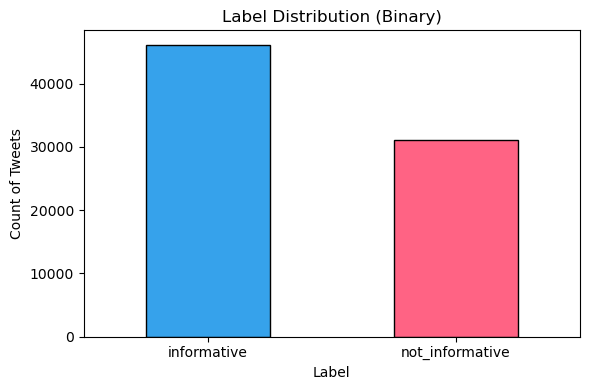

📊 Saved label distribution plot to: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\label_distribution.png


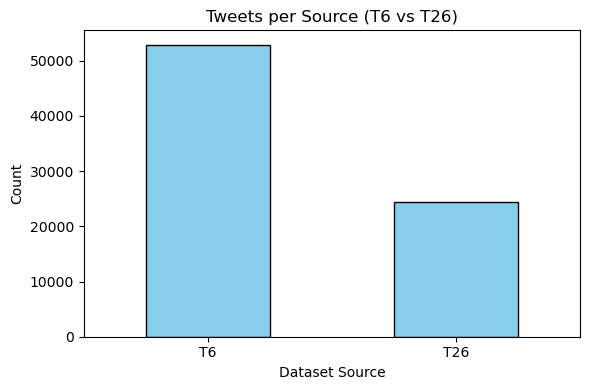

📊 Saved source distribution plot to: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\source_distribution.png

Binary Label Counts:
 label_binary
informative        46134
not_informative    31077
Name: count, dtype: int64

Source Counts:
 source
T6     52852
T26    24359
Name: count, dtype: int64


In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Load cleaned dataset ===
path = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\merged_final_labels.csv"
df = pd.read_csv(path, low_memory=False)

print("✅ Dataset loaded:", df.shape)
print("\nColumns:", list(df.columns))

# === Define output folder for saving plots ===
output_dir = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals"
os.makedirs(output_dir, exist_ok=True)  # create folder if it doesn't exist

# --- Label Binary Distribution ---
label_counts = df['label_binary'].value_counts()

plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', edgecolor='black', color=['#36A2EB', '#FF6384'])
plt.title("Label Distribution (Binary)")
plt.xlabel("Label")
plt.ylabel("Count of Tweets")
plt.xticks(rotation=0)
plt.tight_layout()

# Save and show
label_plot_path = os.path.join(output_dir, "label_distribution.png")
plt.savefig(label_plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"📊 Saved label distribution plot to: {label_plot_path}")

# --- Source Distribution ---
source_counts = df['source'].value_counts()

plt.figure(figsize=(6,4))
source_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Tweets per Source (T6 vs T26)")
plt.xlabel("Dataset Source")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()

# Save and show
source_plot_path = os.path.join(output_dir, "source_distribution.png")
plt.savefig(source_plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"📊 Saved source distribution plot to: {source_plot_path}")

# --- Quick table summary ---
print("\nBinary Label Counts:\n", label_counts)
print("\nSource Counts:\n", source_counts)

### STEP 3.2 — Event-Level Distribution & Top Events Analysis

Top 15 events by tweet count:
 event
2013_Oklahoma_Tornado            9178
2013_Alberta_Floods              9173
2012_Sandy_Hurricane             9169
2013_Boston_Bombings             8993
2013_West_Texas_Explosion        8668
2013_Queensland_Floods           7671
2012_Costa_Rica_earthquake       1174
2012_Colorado_wildfires          1158
2013_Queensland_floods           1141
2013_Savar_building_collapse     1099
2013_Russia_meteor               1083
2013_Australia_bushfire          1052
2013_Alberta_floods               963
2013_Lac_Megantic_train_crash     955
2013_Boston_bombings              945
Name: count, dtype: int64


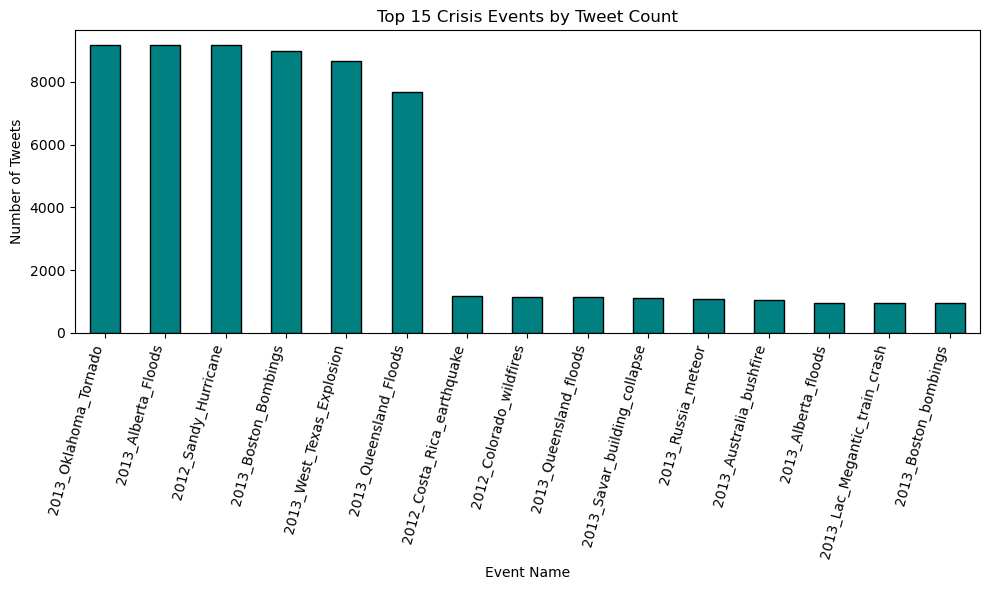

📊 Saved event plot to: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\top_events_by_tweet_count.png


In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Load the final labeled dataset ===
path = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\merged_final_labels.csv"
df = pd.read_csv(path, low_memory=False)

# === Prepare output folder for saving plots ===
output_dir = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals"
os.makedirs(output_dir, exist_ok=True)

# --- Count tweets per event ---
event_counts = df['event'].value_counts().sort_values(ascending=False)

print("Top 15 events by tweet count:\n", event_counts.head(15))

# --- Plot ---
plt.figure(figsize=(10,6))
event_counts.head(15).plot(kind='bar', color='teal', edgecolor='black')
plt.title("Top 15 Crisis Events by Tweet Count")
plt.xlabel("Event Name")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=75, ha='right')
plt.tight_layout()

# Save the plot
plot_path = os.path.join(output_dir, "top_events_by_tweet_count.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Saved event plot to: {plot_path}")


### STEP 3.3 : Label Distribution per Source & per Event

Label distribution per source:
 label_binary  informative  not_informative
source                                    
T26                 20401             3958
T6                  25733            27119 



<Figure size 600x400 with 0 Axes>

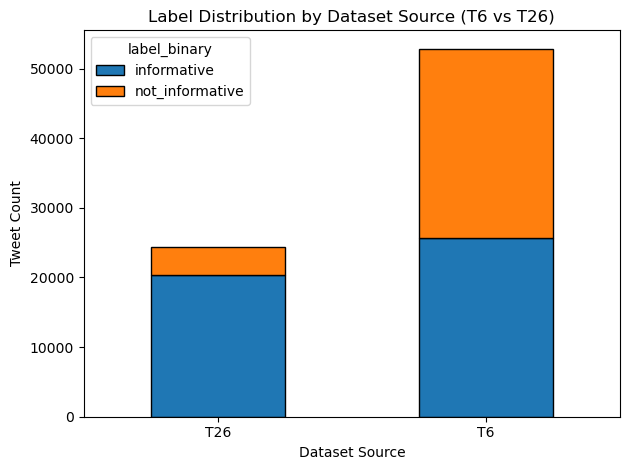

📊 Saved source label distribution plot to: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\label_distribution_by_source.png

Label distribution for Top 5 Events:
 label_binary               informative  not_informative
event                                                  
2012_Sandy_Hurricane              5415             3754
2013_Alberta_Floods               4429             4744
2013_Boston_Bombings              4696             4297
2013_Oklahoma_Tornado             4072             5106
2013_West_Texas_Explosion         3968             4700 



<Figure size 1000x500 with 0 Axes>

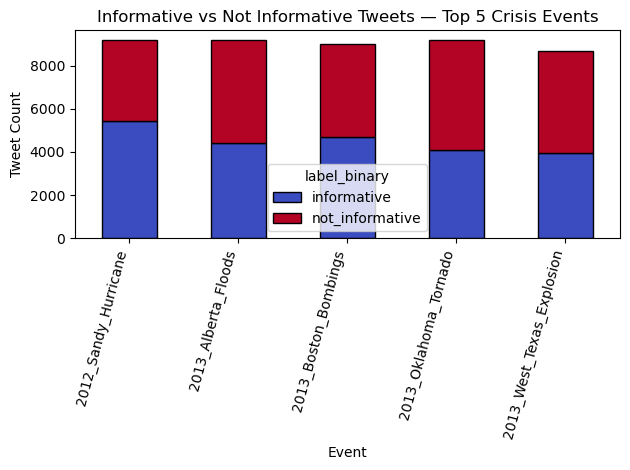

📊 Saved top events label distribution plot to: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\label_distribution_top5_events.png


In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Load dataset ===
path = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\merged_final_labels.csv"
df = pd.read_csv(path, low_memory=False)

# === Define output folder for saving plots ===
output_dir = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals"
os.makedirs(output_dir, exist_ok=True)

# --- 1️⃣ Label distribution per source ---
cross_source = pd.crosstab(df['source'], df['label_binary'])
print("Label distribution per source:\n", cross_source, "\n")

plt.figure(figsize=(6,4))
cross_source.plot(kind='bar', stacked=True, edgecolor='black')
plt.title("Label Distribution by Dataset Source (T6 vs T26)")
plt.xlabel("Dataset Source")
plt.ylabel("Tweet Count")
plt.xticks(rotation=0)
plt.tight_layout()

# Save & show
plot1_path = os.path.join(output_dir, "label_distribution_by_source.png")
plt.savefig(plot1_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"📊 Saved source label distribution plot to: {plot1_path}\n")

# --- 2️⃣ Label distribution across top events ---
top_events = df['event'].value_counts().head(5).index
subset = df[df['event'].isin(top_events)]

cross_event = pd.crosstab(subset['event'], subset['label_binary'])
print("Label distribution for Top 5 Events:\n", cross_event, "\n")

plt.figure(figsize=(10,5))
cross_event.plot(kind='bar', stacked=True, colormap='coolwarm', edgecolor='black')
plt.title("Informative vs Not Informative Tweets — Top 5 Crisis Events")
plt.xlabel("Event")
plt.ylabel("Tweet Count")
plt.xticks(rotation=75, ha='right')
plt.tight_layout()

# Save & show
plot2_path = os.path.join(output_dir, "label_distribution_top5_events.png")
plt.savefig(plot2_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"📊 Saved top events label distribution plot to: {plot2_path}")


### STEP 3.4 — Text Exploration & Keyword Insights

Top 20 words — Informative:
 [('rt', 21524), ('the', 21357), ('in', 17014), ('to', 14407), ('of', 10877), ('a', 10316), ('and', 8953), ('for', 7256), ('is', 6002), ('s', 5145), ('i', 4962), ('boston', 4588), ('at', 4492), ('flood', 4486), ('hurricane', 4404), ('on', 4312), ('explosion', 3892), ('this', 3777), ('de', 3567), ('are', 3445)]

Top 20 words — Not Informative:
 [('i', 13085), ('the', 10385), ('to', 8336), ('a', 7116), ('you', 6121), ('and', 6056), ('in', 5033), ('it', 4448), ('my', 4417), ('of', 4060), ('is', 3978), ('s', 3679), ('t', 3352), ('that', 3329), ('for', 3284), ('me', 2951), ('on', 2940), ('m', 2747), ('at', 2653), ('this', 2618)]


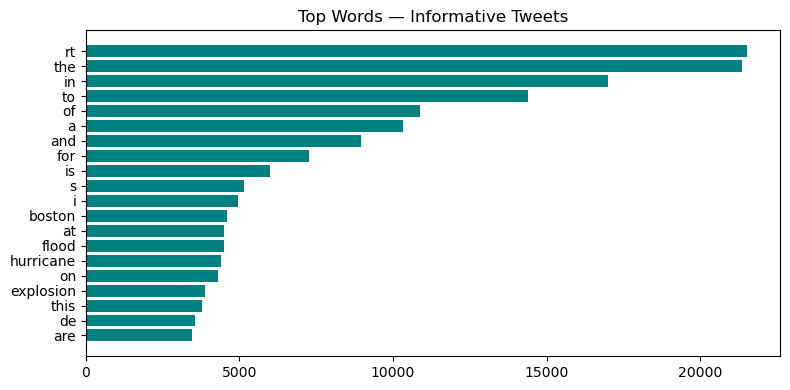

📊 Saved plot: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\top_words_informative.png


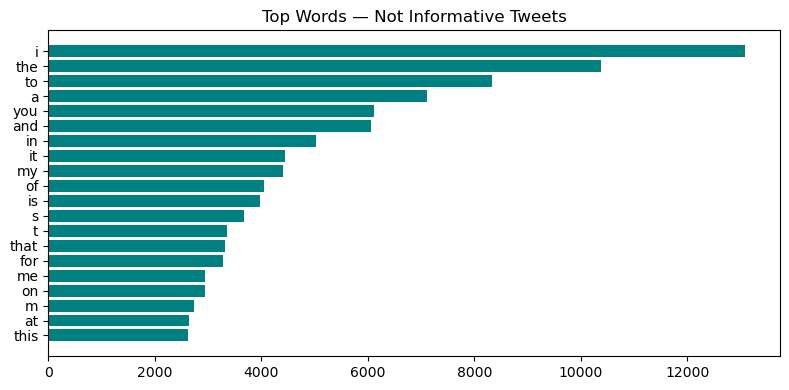

📊 Saved plot: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\top_words_not_informative.png


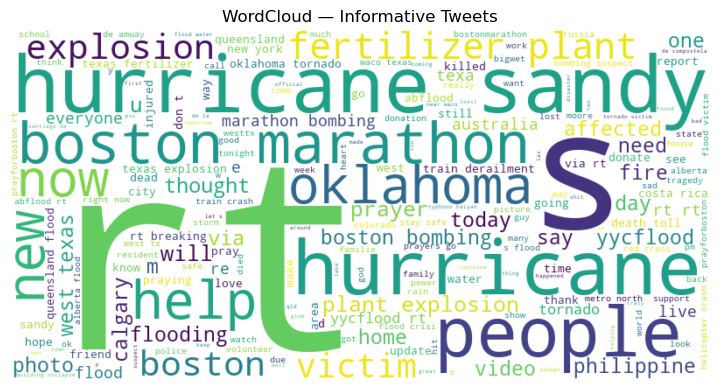

☁️ Saved WordCloud: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\wordcloud_informative.png


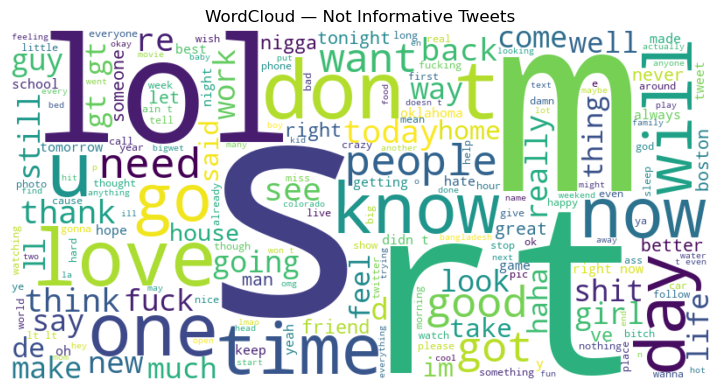

☁️ Saved WordCloud: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\wordcloud_not_informative.png


In [12]:
import os
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# === Load dataset ===
path = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\merged_final_labels.csv"
df = pd.read_csv(path, low_memory=False)

# === Prepare output folder ===
output_dir = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals"
os.makedirs(output_dir, exist_ok=True)

# --- Subsets ---
informative_texts = " ".join(df[df['label_binary'] == "informative"]['clean_text'].dropna())
notinfo_texts     = " ".join(df[df['label_binary'] == "not_informative"]['clean_text'].dropna())

# --- Function: Top words ---
def get_top_words(text, n=20):
    tokens = text.split()
    freq = Counter(tokens)
    return freq.most_common(n)

# Compute frequencies
top_informative = get_top_words(informative_texts)
top_notinfo     = get_top_words(notinfo_texts)

print("Top 20 words — Informative:\n", top_informative)
print("\nTop 20 words — Not Informative:\n", top_notinfo)

# --- Function: Bar chart for comparison ---
def plot_top_words(freq_list, title, filename):
    words, counts = zip(*freq_list)
    plt.figure(figsize=(8,4))
    plt.barh(words[::-1], counts[::-1], color='teal')
    plt.title(title)
    plt.tight_layout()

    # Save + show
    save_path = os.path.join(output_dir, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"📊 Saved plot: {save_path}")

# Plot & save
plot_top_words(top_informative, "Top Words — Informative Tweets", "top_words_informative.png")
plot_top_words(top_notinfo, "Top Words — Not Informative Tweets", "top_words_not_informative.png")

# --- Optional WordClouds ---
def generate_wordcloud(text, title, filename):
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud — {title}")
    plt.tight_layout()

    # Save + show
    save_path = os.path.join(output_dir, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"☁️ Saved WordCloud: {save_path}")

# Generate and save both WordClouds
generate_wordcloud(informative_texts, "Informative Tweets", "wordcloud_informative.png")
generate_wordcloud(notinfo_texts, "Not Informative Tweets", "wordcloud_not_informative.png")


### STEP 3.5 : Temporal Trend Analysis (EDA over Time)

Loaded rows: 77211
Parsing timestamps... (this may take a few seconds)
Rows with parsed timestamps: 24359
Timestamp date range: 2012-05-18 11:04:31+00:00 to 2013-12-31 16:22:26+00:00

Top events by available timestamps:
 event
2012_Costa_Rica_earthquake       1174
2012_Colorado_wildfires          1158
2013_Queensland_floods           1141
2013_Savar_building_collapse     1099
2013_Russia_meteor               1083
2013_Australia_bushfire          1052
2013_Alberta_floods               963
2013_Lac_Megantic_train_crash     955
2013_Boston_bombings              945
2012_Venezuela_refinery           941
2013_Colorado_floods              940
2012_Typhoon_Pablo                935
2013_Typhoon_Yolanda              930
2012_Guatemala_earthquake         912
2013_LA_airport_shootings         908
2012_Italy_earthquakes            907
2013_Manila_floods                903
2013_West_Texas_explosion         902
2013_Glasgow_helicopter_crash     878
2013_Sardinia_floods              871
2013_Bohol_ea

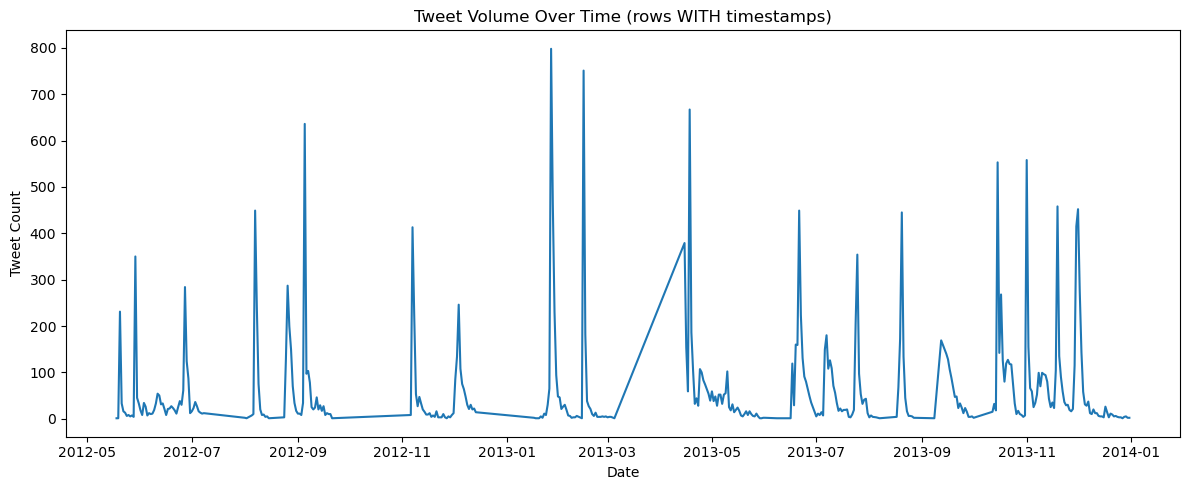

Saved global timeline to: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\timeline_all_timestamped_events.png


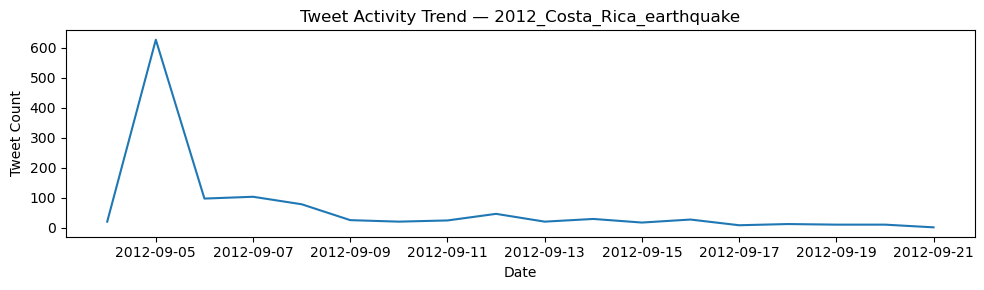

Saved plot for 2012_Costa_Rica_earthquake -> C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\timeline_2012_Costa_Rica_earthquake.png


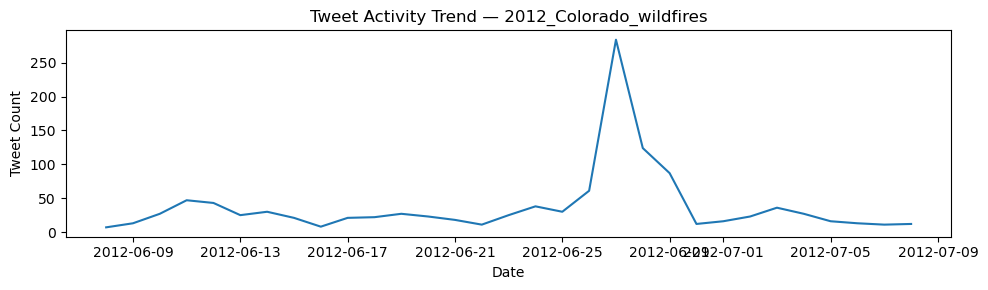

Saved plot for 2012_Colorado_wildfires -> C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\timeline_2012_Colorado_wildfires.png


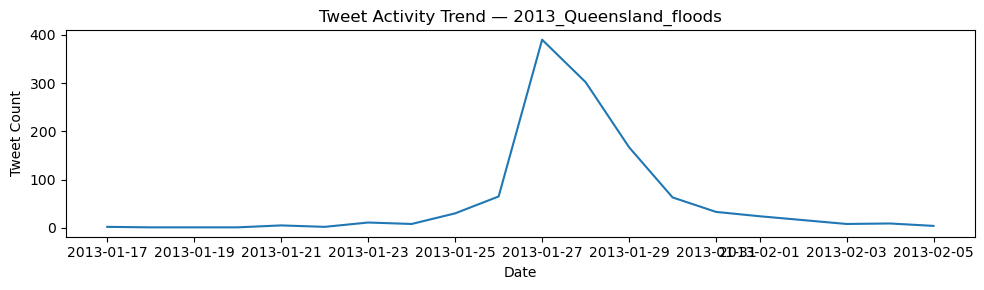

Saved plot for 2013_Queensland_floods -> C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\timeline_2013_Queensland_floods.png


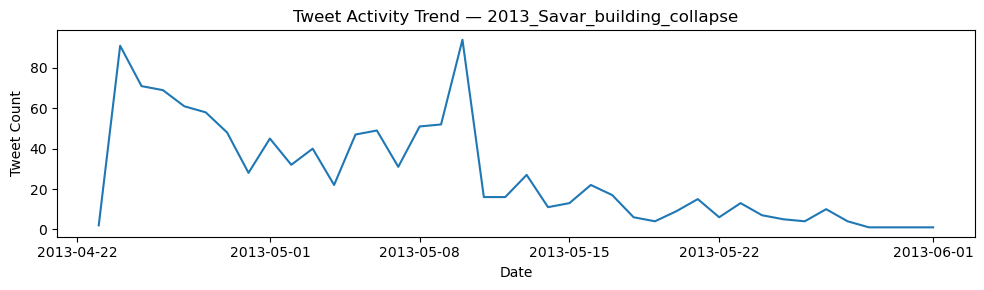

Saved plot for 2013_Savar_building_collapse -> C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\timeline_2013_Savar_building_collapse.png


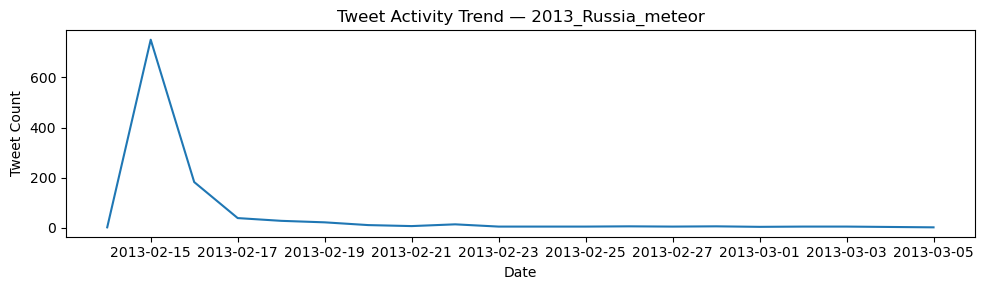

Saved plot for 2013_Russia_meteor -> C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\timeline_2013_Russia_meteor.png


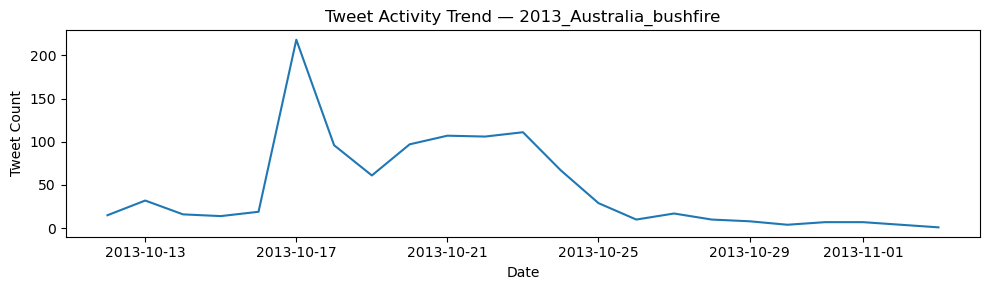

Saved plot for 2013_Australia_bushfire -> C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\timeline_2013_Australia_bushfire.png


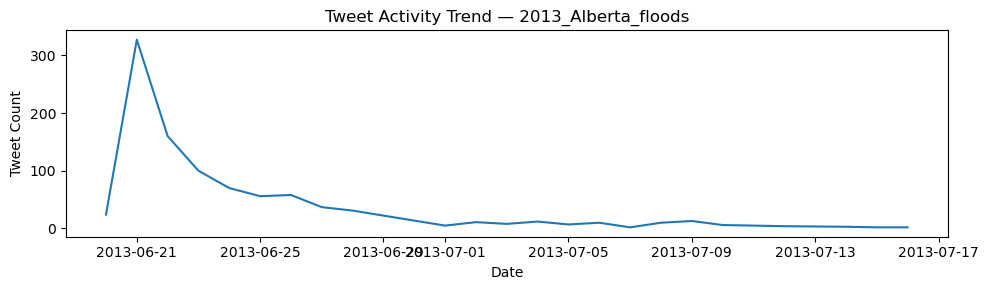

Saved plot for 2013_Alberta_floods -> C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\timeline_2013_Alberta_floods.png


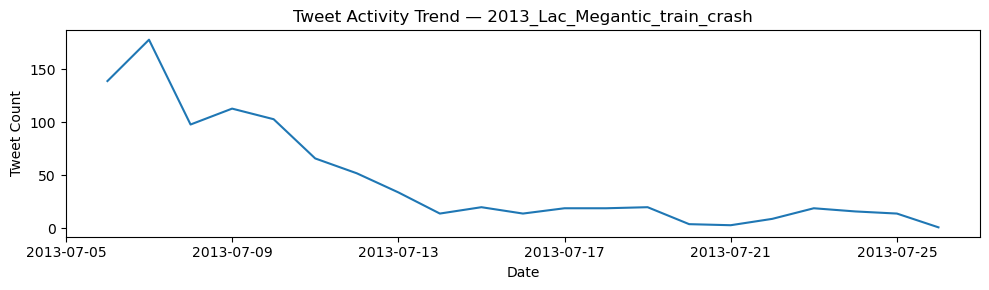

Saved plot for 2013_Lac_Megantic_train_crash -> C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\timeline_2013_Lac_Megantic_train_crash.png


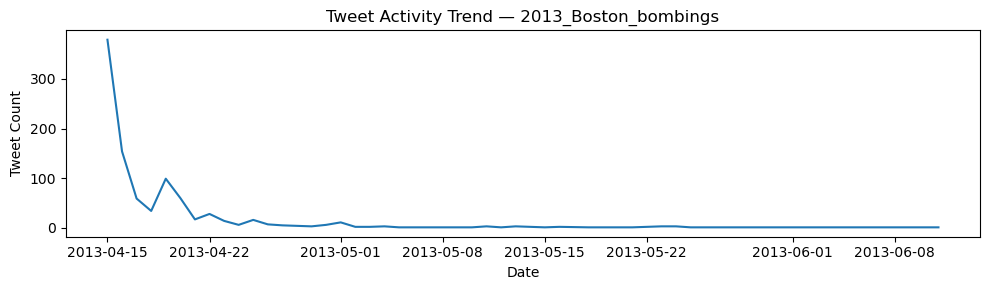

Saved plot for 2013_Boston_bombings -> C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\timeline_2013_Boston_bombings.png


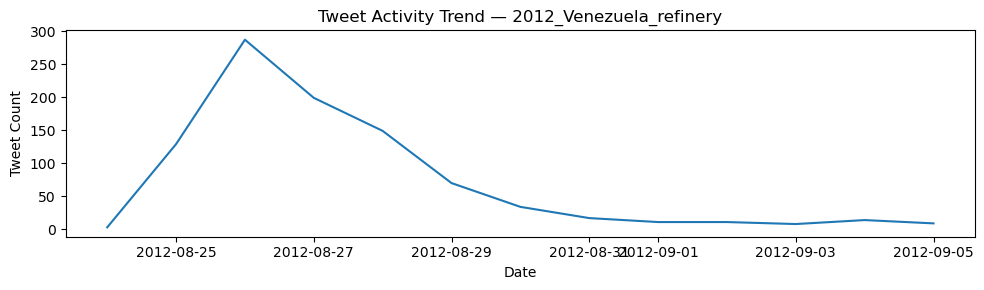

Saved plot for 2012_Venezuela_refinery -> C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\timeline_2012_Venezuela_refinery.png

Top 15 events by peak day tweet count (with duration):
                        event  tweet_count                  first_ts                   last_ts  duration_days  total_tweets
           2013_Russia_meteor          751 2013-02-14 07:35:37+00:00 2013-03-05 20:38:17+00:00             20          1083
    2013_West_Texas_explosion          633 2013-04-18 00:30:41+00:00 2013-05-15 20:33:10+00:00             28           902
   2012_Costa_Rica_earthquake          627 2012-09-04 07:15:02+00:00 2012-09-21 01:52:54+00:00             17          1174
    2013_LA_airport_shootings          551 2013-11-01 09:22:04+00:00 2013-11-12 22:59:09+00:00             12           908
        2013_Bohol_earthquake          539 2013-10-14 07:30:44+00:00 2013-10-25 05:06:57+00:00             11           835
      2012_Philipinnes_floods       

In [13]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# === Configuration ===
data_root = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed"
infile = os.path.join(data_root, "merged_final_labels.csv")

# Derive project-level reports folder from data_root:
project_root = os.path.dirname(os.path.dirname(data_root))
reports_dir = os.path.join(project_root, "reports", "eda_visuals")
os.makedirs(reports_dir, exist_ok=True)

TOP_N_EVENTS = 10  

# === Load raw file (no dtype coercion that breaks timestamps) ===
raw = pd.read_csv(infile, low_memory=False, dtype=str)
print("Loaded rows:", len(raw))

# === Robust timestamp parsing function ===
def parse_ts(x):
    if pd.isna(x):
        return pd.NaT
    s = str(x).strip()
    if s == "" or s.lower() == "nan":
        return pd.NaT

    # common CrisisLex format: 'Fri Jun 08 10:23:20 +0000 2012'
    formats = [
        "%a %b %d %H:%M:%S %z %Y",
        "%a %b %d %H:%M:%S %Y",        # no timezone
        "%Y-%m-%d %H:%M:%S%z",
        "%Y-%m-%d %H:%M:%S",
        "%Y-%m-%dT%H:%M:%SZ",
    ]
    for fmt in formats:
        try:
            ts = pd.to_datetime(s, format=fmt, errors='raise')
            if ts.tzinfo is None:
                return ts
            return ts.tz_convert("UTC")
        except Exception:
            pass
    try:
        return pd.to_datetime(s, errors='coerce', utc=True)
    except Exception:
        return pd.NaT

# === Apply parser ===
print("Parsing timestamps... (this may take a few seconds)")
raw['timestamp_parsed'] = raw['timestamp'].apply(parse_ts)

df_ts = raw[raw['timestamp_parsed'].notna()].copy()
df_ts['timestamp_parsed'] = pd.to_datetime(df_ts['timestamp_parsed'], errors='coerce')
df_ts = df_ts[df_ts['timestamp_parsed'].notna()].copy()
df_ts['date'] = df_ts['timestamp_parsed'].dt.date

print(f"Rows with parsed timestamps: {len(df_ts)}")
if len(df_ts) > 0:
    print("Timestamp date range:", df_ts['timestamp_parsed'].min(), "to", df_ts['timestamp_parsed'].max())
else:
    print("No parsed timestamps found — skipping plots.")

# === Which events have timestamps ===
if len(df_ts) > 0:
    ts_counts_by_event = df_ts.groupby('event').size().sort_values(ascending=False)
    print("\nTop events by available timestamps:\n", ts_counts_by_event.head(30))
else:
    ts_counts_by_event = pd.Series(dtype=int)

# === Filename cleaner ===
def safe_fname(s):
    s = re.sub(r"[^\w\s-]", "", str(s))
    s = re.sub(r"\s+", "_", s)
    return s[:150]

# === Global time-series ===
if len(df_ts) > 0:
    daily_counts = df_ts.groupby('date').size().sort_index()
    plt.figure(figsize=(12,5))
    daily_counts.plot()
    plt.title("Tweet Volume Over Time (rows WITH timestamps)")
    plt.xlabel("Date")
    plt.ylabel("Tweet Count")
    plt.tight_layout()

    global_plot_path = os.path.join(reports_dir, "timeline_all_timestamped_events.png")
    plt.savefig(global_plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved global timeline to:", global_plot_path)
else:
    print("Skipping global timeline — no timestamped rows.")

# === Per-event daily trends ===
if len(df_ts) > 0 and len(ts_counts_by_event) > 0:
    top_events = ts_counts_by_event.head(TOP_N_EVENTS).index.tolist()
    for e in top_events:
        event_df = df_ts[df_ts['event'] == e].copy()
        if event_df.empty:
            continue
        subset = event_df.groupby(event_df['timestamp_parsed'].dt.date).size().sort_index()
        if subset.empty:
            continue

        plt.figure(figsize=(10,3))
        subset.plot()
        plt.title(f"Tweet Activity Trend — {e}")
        plt.xlabel("Date")
        plt.ylabel("Tweet Count")
        plt.tight_layout()

        p_reports = os.path.join(reports_dir, f"timeline_{safe_fname(e)}.png")
        plt.savefig(p_reports, dpi=150, bbox_inches='tight')
        plt.show()
        print("Saved plot for", e, "->", p_reports)
else:
    print("Skipping per-event plots — no timestamped events.")

# === Peak day and duration summary ===
if len(df_ts) > 0:
    daily_counts_event = df_ts.groupby(['event', df_ts['timestamp_parsed'].dt.date]).size().reset_index(name='tweet_count')
    idx = daily_counts_event.groupby('event')['tweet_count'].idxmax()
    peak_days = daily_counts_event.loc[idx].sort_values(by='tweet_count', ascending=False)

    range_df = df_ts.groupby('event').agg(
        first_ts=('timestamp_parsed','min'),
        last_ts=('timestamp_parsed','max'),
        total_tweets=('timestamp_parsed','count')
    ).reset_index()
    range_df['duration_days'] = (range_df['last_ts'] - range_df['first_ts']).dt.days + 1

    summary = peak_days.merge(range_df, on='event').sort_values(by='tweet_count', ascending=False)
    summary_subset = summary[['event','tweet_count','first_ts','last_ts','duration_days','total_tweets']].head(15)
    print("\nTop 15 events by peak day tweet count (with duration):")
    print(summary_subset.to_string(index=False))

    summary_csv_path = os.path.join(reports_dir, "temporal_summary_by_event.csv")
    summary.to_csv(summary_csv_path, index=False)
    print("\nSaved temporal summary to:", summary_csv_path)
else:
    print("Skipping temporal summary — no timestamped rows.")

# === Note about T6 events ===
all_events = sorted(raw['event'].dropna().unique())
events_with_ts = set(ts_counts_by_event.index.tolist())
events_zero_ts = [e for e in all_events if e not in events_with_ts]
print("\nEvents with ZERO parsed timestamps (likely T6-only events):")
print(events_zero_ts)


### STEP 4.1 — Dataset Preparation & Train/Test Split

In [14]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# === Configuration ===
project_root = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier"
data_root = os.path.join(project_root, "data", "processed")
infile = os.path.join(data_root, "merged_final_labels.csv")

# Output folder
os.makedirs(data_root, exist_ok=True)

# === Load dataset ===
df = pd.read_csv(infile, low_memory=False)
print("✅ Dataset loaded:", df.shape)

# === Keep only the required fields and drop missing ===
df = df[['clean_text', 'label_binary', 'source', 'event']].dropna().reset_index(drop=True)
print("Full dataset shape (after dropna):", df.shape)

# === Map binary labels to integers ===
df['label_int'] = df['label_binary'].map({'informative': 1, 'not_informative': 0})

# === Quick class balance check ===
print("\nOverall label distribution:")
print(df['label_binary'].value_counts())

# === Stratified train/test split (80/20) ===
train_df, test_df = train_test_split(
    df,
    test_size=0.20,
    stratify=df['label_int'],
    random_state=42
)

print("\nTrain shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nTrain label distribution:")
print(train_df['label_binary'].value_counts())
print("\nTest label distribution:")
print(test_df['label_binary'].value_counts())

# === Save outputs in processed/ ===
train_path = os.path.join(data_root, "train_set.csv")
test_path  = os.path.join(data_root, "test_set.csv")
train_df.to_csv(train_path, index=False, encoding='utf-8')
test_df.to_csv(test_path, index=False, encoding='utf-8')

print("\n✅ Saved splits:")
print("Train ->", train_path)
print("Test  ->", test_path)


✅ Dataset loaded: (77211, 13)
Full dataset shape (after dropna): (77211, 4)

Overall label distribution:
label_binary
informative        46134
not_informative    31077
Name: count, dtype: int64

Train shape: (61768, 5)
Test shape: (15443, 5)

Train label distribution:
label_binary
informative        36907
not_informative    24861
Name: count, dtype: int64

Test label distribution:
label_binary
informative        9227
not_informative    6216
Name: count, dtype: int64

✅ Saved splits:
Train -> C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\train_set.csv
Test  -> C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\test_set.csv


### STEP 4.2 — Text Feature Extraction (TF-IDF Vectorization)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import os

data_root = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed"

# Load splits
train_df = pd.read_csv(os.path.join(data_root, "train_set.csv"))
test_df  = pd.read_csv(os.path.join(data_root, "test_set.csv"))

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# === TF-IDF vectorization ===
vectorizer = TfidfVectorizer(
    max_features=10000,        # top 10K words
    ngram_range=(1,2),         # unigrams + bigrams
    min_df=3,                  # ignore rare words
    max_df=0.8,                # ignore overly common words
    stop_words='english'
)

X_train = vectorizer.fit_transform(train_df['clean_text'])
X_test  = vectorizer.transform(test_df['clean_text'])

y_train = train_df['label_int']
y_test  = test_df['label_int']

print("\n✅ TF-IDF vectorization done!")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\nSample feature names:", vectorizer.get_feature_names_out()[:15])


Train shape: (61768, 5)
Test shape: (15443, 5)

✅ TF-IDF vectorization done!
X_train shape: (61768, 10000)
X_test shape: (15443, 10000)

Sample feature names: ['aaron' 'ab' 'ab job' 'abbiamo' 'abbott' 'abbott says' 'abc' 'abc news'
 'abc online' 'abcnews' 'abemerg' 'abemerg abflood' 'abflood'
 'abflood ableg' 'abflood cdnpoli']


### STEP 4.3 — Baseline Model Training & Evaluation

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Linear SVM": LinearSVC(),
    "Naive Bayes": MultinomialNB()
}

results = {}

for name, model in models.items():
    print(f"\n🔹 Training {name} ...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    print(f"✅ {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, target_names=['not_informative', 'informative']))

    results[name] = acc

print("\n📊 Summary of model accuracies:")
for name, acc in results.items():
    print(f"{name:<25} {acc:.4f}")



🔹 Training Logistic Regression ...
✅ Logistic Regression Accuracy: 0.9206
                 precision    recall  f1-score   support

not_informative       0.92      0.88      0.90      6216
    informative       0.92      0.95      0.93      9227

       accuracy                           0.92     15443
      macro avg       0.92      0.91      0.92     15443
   weighted avg       0.92      0.92      0.92     15443


🔹 Training Linear SVM ...
✅ Linear SVM Accuracy: 0.9218
                 precision    recall  f1-score   support

not_informative       0.92      0.89      0.90      6216
    informative       0.93      0.94      0.94      9227

       accuracy                           0.92     15443
      macro avg       0.92      0.92      0.92     15443
   weighted avg       0.92      0.92      0.92     15443


🔹 Training Naive Bayes ...
✅ Naive Bayes Accuracy: 0.8734
                 precision    recall  f1-score   support

not_informative       0.85      0.83      0.84      6216
    

### STEP 4.4 — Model Comparison & Visualization

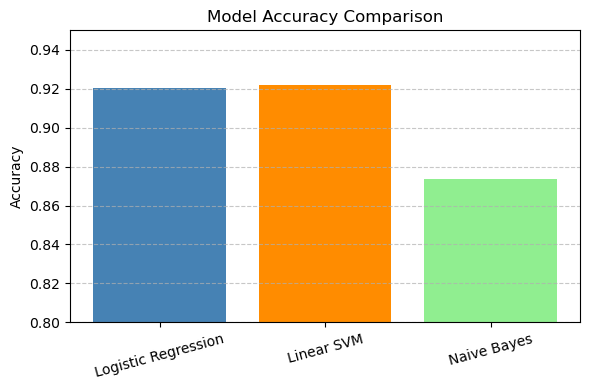

✅ Saved accuracy comparison plot to: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\model_accuracy_comparison.png


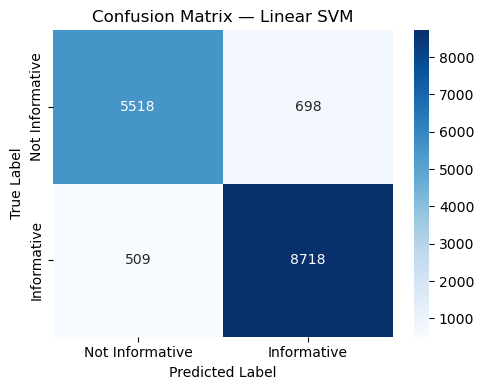

✅ Saved confusion matrix plot to: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\confusion_matrix_linear_svm.png

✅ Final Best Model: Linear SVM
Accuracy: 0.9218


In [17]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score

# === Configuration ===
project_root = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier"
reports_dir = os.path.join(project_root, "reports", "eda_visuals")
os.makedirs(reports_dir, exist_ok=True)

# === 1️⃣ Accuracy Comparison Bar Chart ===
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values(), color=['steelblue', 'darkorange', 'lightgreen'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.ylim(0.8, 0.95)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

acc_path = os.path.join(reports_dir, "model_accuracy_comparison.png")
plt.savefig(acc_path, dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved accuracy comparison plot to:", acc_path)

# === 2️⃣ Confusion Matrix for the Best Model (Linear SVM) ===
best_model = LinearSVC()
best_model.fit(X_train, y_train)
svm_preds = best_model.predict(X_test)

cm = confusion_matrix(y_test, svm_preds)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Not Informative', 'Informative'],
    yticklabels=['Not Informative', 'Informative']
)
plt.title("Confusion Matrix — Linear SVM")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()

cm_path = os.path.join(reports_dir, "confusion_matrix_linear_svm.png")
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved confusion matrix plot to:", cm_path)

# === 3️⃣ Print final accuracy again ===
print("\n✅ Final Best Model: Linear SVM")
print(f"Accuracy: {accuracy_score(y_test, svm_preds):.4f}")


### Calibrate & Save Linear SVM, Vectorizer, Label Map & Metadata

In [18]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
import joblib, os, json
from datetime import datetime

# --- Paths ---
MODELS_DIR = os.path.join(project_root, "data", "processed", "models")
os.makedirs(MODELS_DIR, exist_ok=True)

# --- Calibrate trained Linear SVM ---
print("🔄 Calibrating Linear SVM ...")
X_train_cv, X_calib, y_train_cv, y_calib = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
)

# Use correct keyword for your sklearn version
try:
    calibrated_model = CalibratedClassifierCV(estimator=best_model, method="sigmoid", cv="prefit")
except TypeError:
    calibrated_model = CalibratedClassifierCV(base_estimator=best_model, method="sigmoid", cv="prefit")

calibrated_model.fit(X_calib, y_calib)
print("✅ Calibration complete.")

# --- Save calibrated model ---
calib_path = os.path.join(MODELS_DIR, "linear_svm_calibrated.pkl")
joblib.dump(calibrated_model, calib_path)
print("✅ Calibrated model saved to:", calib_path)

# --- Save TF-IDF vectorizer ---
if 'vectorizer' in globals():
    vect_path = os.path.join(MODELS_DIR, "tfidf_vectorizer.pkl")
    joblib.dump(vectorizer, vect_path)
    print("✅ Vectorizer saved to:", vect_path)
else:
    print("⚠️ Vectorizer variable not found — skipped saving.")

# --- Save label_map.json ---
label_map = {"0": "not_informative", "1": "informative"}
label_map_path = os.path.join(MODELS_DIR, "label_map.json")
with open(label_map_path, "w", encoding="utf-8") as f:
    json.dump(label_map, f, indent=2)
print("✅ Label map saved:", label_map_path)

# --- Save metadata.json ---
metadata = {
    "model_name": "LinearSVC (Calibrated)",
    "version": "v1.0",
    "date_saved": datetime.utcnow().isoformat() + "Z",
    "method": "sigmoid calibration on 15% holdout",
    "label_map": label_map
}
metadata_path = os.path.join(MODELS_DIR, "metadata.json")
with open(metadata_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)
print("✅ Metadata saved:", metadata_path)

# --- Verify ---
print("\n📁 Verification:")
for file in ["linear_svm_calibrated.pkl", "tfidf_vectorizer.pkl", "label_map.json", "metadata.json"]:
    full_path = os.path.join(MODELS_DIR, file)
    print(f" - {file}: {'FOUND ✅' if os.path.exists(full_path) else '❌ MISSING'}")

🔄 Calibrating Linear SVM ...
✅ Calibration complete.
✅ Calibrated model saved to: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\models\linear_svm_calibrated.pkl
✅ Vectorizer saved to: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\models\tfidf_vectorizer.pkl
✅ Label map saved: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\models\label_map.json
✅ Metadata saved: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\models\metadata.json

📁 Verification:
 - linear_svm_calibrated.pkl: FOUND ✅
 - tfidf_vectorizer.pkl: FOUND ✅
 - label_map.json: FOUND ✅
 - metadata.json: FOUND ✅


### STEP 5 — Model Explainability & Feature Insights

🔹 Top 20 Features — Informative Tweets:
['hurricane' 'flood' 'yycflood' 'abflood' 'sandy' 'prayforboston'
 'explosion' 'westexplosion' 'tornado' 'flooding' 'floods'
 'bostonmarathon' 'highparkfire' 'hurricanesandy' 'bombing' 'storm'
 'marathon' 'tsarnaev' 'prayfortexas' 'frankenstorm']

🔸 Top 20 Features — Not Informative Tweets:
['sandy hurricane' 'yycflood abflood' 'en texas' 'boston bostonmarathon'
 'spin' 'tat' 'afghanistan' 'prayforboston prayfortexas' 'filipinas'
 'mexican' 'beast' 'pussy' 'rt est' 'haunted' 'explosion death' 'lips'
 'earthquake sismo' 'bigwet queensland' 'hung' 'affected hurricane']


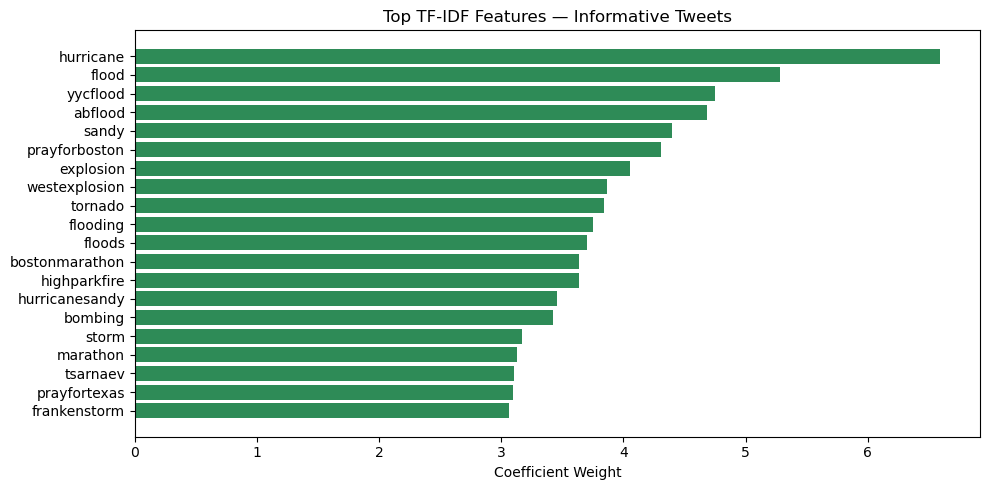

✅ Saved plot: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\top_features_informative.png


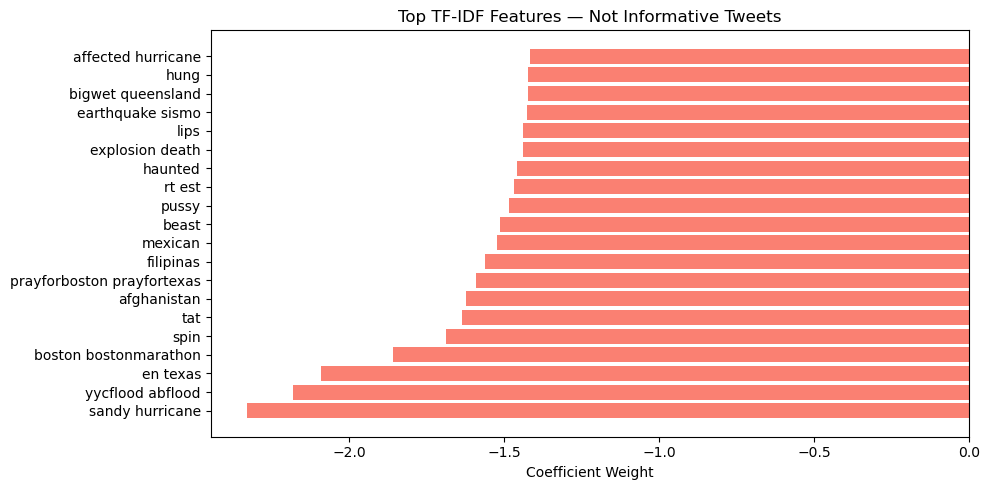

✅ Saved plot: C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\reports\eda_visuals\top_features_not_informative.png


In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

# === Configuration ===
project_root = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier"
reports_dir = os.path.join(project_root, "reports", "eda_visuals")
os.makedirs(reports_dir, exist_ok=True)

# === Train model on training data ===
svm_final = LinearSVC()
svm_final.fit(X_train, y_train)

# === Get feature names and weights ===
feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = svm_final.coef_.ravel()

# === Sort features ===
top_positive_idx = np.argsort(coefficients)[-20:][::-1]
top_negative_idx = np.argsort(coefficients)[:20]

# === Prepare top terms ===
top_informative = feature_names[top_positive_idx]
top_not_informative = feature_names[top_negative_idx]

print("🔹 Top 20 Features — Informative Tweets:")
print(top_informative)

print("\n🔸 Top 20 Features — Not Informative Tweets:")
print(top_not_informative)

# === Plot Top Informative Features ===
plt.figure(figsize=(10,5))
plt.barh(top_informative[::-1], coefficients[top_positive_idx][::-1], color='seagreen')
plt.title("Top TF-IDF Features — Informative Tweets")
plt.xlabel("Coefficient Weight")
plt.tight_layout()
path_info = os.path.join(reports_dir, "top_features_informative.png")
plt.savefig(path_info, dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved plot:", path_info)

# === Plot Top Not Informative Features ===
plt.figure(figsize=(10,5))
plt.barh(top_not_informative, coefficients[top_negative_idx], color='salmon')
plt.title("Top TF-IDF Features — Not Informative Tweets")
plt.xlabel("Coefficient Weight")
plt.tight_layout()
path_notinfo = os.path.join(reports_dir, "top_features_not_informative.png")
plt.savefig(path_notinfo, dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved plot:", path_notinfo)


### Step 5.1: Explainability

### STEP 6 — Model Saving & Streamlit Deployment Prep

In [20]:
import os
import joblib

# === Configuration ===
project_root = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier"
output_dir = os.path.join(project_root, "data", "processed", "models")
os.makedirs(output_dir, exist_ok=True)

# === Save model and TF-IDF vectorizer ===
model_path = os.path.join(output_dir, "linear_svm_model.pkl")
vectorizer_path = os.path.join(output_dir, "tfidf_vectorizer.pkl")

joblib.dump(svm_final, model_path)
joblib.dump(vectorizer, vectorizer_path)

print("✅ Model and vectorizer saved successfully!")
print(f"Model saved to:       {model_path}")
print(f"Vectorizer saved to:  {vectorizer_path}")

# --- Optional sanity check ---
if os.path.exists(model_path) and os.path.exists(vectorizer_path):
    model_size = os.path.getsize(model_path) / 1024
    vect_size = os.path.getsize(vectorizer_path) / 1024
    print(f"\n📦 File sizes:")
    print(f" - linear_svm_model.pkl: {model_size:.1f} KB")
    print(f" - tfidf_vectorizer.pkl: {vect_size:.1f} KB")
else:
    print("⚠️ Warning: Model or vectorizer file not found — check save paths.")


✅ Model and vectorizer saved successfully!
Model saved to:       C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\models\linear_svm_model.pkl
Vectorizer saved to:  C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\models\tfidf_vectorizer.pkl

📦 File sizes:
 - linear_svm_model.pkl: 78.8 KB
 - tfidf_vectorizer.pkl: 375.1 KB


### Model confirmation

In [21]:
import os, joblib

model_path = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\models\linear_svm_model.pkl"
vect_path  = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\models\tfidf_vectorizer.pkl"

if os.path.exists(model_path) and os.path.exists(vect_path):
    model = joblib.load(model_path)
    vect  = joblib.load(vect_path)
    print("✅ Model and vectorizer loaded successfully!")
else:
    print("❌ Missing files — check paths.")


✅ Model and vectorizer loaded successfully!


### Prediction check

In [26]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import joblib, os

sample_text = "Massive flooding in Manila, emergency crews rescuing people"
X = vect.transform([sample_text])
pred = model_calibrated.predict(X)[0]
conf = model_calibrated.predict_proba(X)[0][pred]

print(f"Prediction: {pred}")
print(f"Confidence (probability): {conf:.3f}")

Prediction: 1
Confidence (probability): 0.998


### Prediction check using calibrated SVM

In [27]:
base_svm = LinearSVC(random_state=42, max_iter=20000)
model_calibrated = CalibratedClassifierCV(base_svm, cv=5)

print("Training calibrated SVM (this might take 2–3 minutes)...")
model_calibrated.fit(X_train, y_train)

models_dir = r"C:\Users\ShaownJony\Downloads\Project\AI-Crisis-Tweet-Classifier\data\processed\models"
os.makedirs(models_dir, exist_ok=True)
joblib.dump(model_calibrated, os.path.join(models_dir, "linear_svm_calibrated.pkl"))
print("✅ Calibrated model saved successfully!")

sample_text = "Massive flooding in Manila, emergency crews rescuing people"
X = vect.transform([sample_text])
pred = model_calibrated.predict(X)[0]
prob = model_calibrated.predict_proba(X)[0][pred]
print(f"Prediction: {pred}, Confidence: {prob:.3f}")


Training calibrated SVM (this might take 2–3 minutes)...
✅ Calibrated model saved successfully!
Prediction: 1, Confidence: 0.998
